In [2]:
from IPython import display

import glob
#import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

2024-05-15 13:56:03.313617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# VAEs as probabilistic generative models
This is a recap of the blog post by Matthew N. Bernstein available at https://mbernste.github.io/posts/vae/ .  

VAE define a probabilistic generative process for generating data points that reside in some $D$-dimensional space. This generative process goes as follow: first sample a latent variable $\textbf{z} \in \mathbb{R}^J$, where $J<D$  from some distribution such as the standard normal, then use a deterministic function $\Psi$ to map $\textbf{z}$ to parameters of another distribution used to sample $\textbf{x} \in \mathbb{R}^D$ . Most commonly we construct $\Psi$ from $\textbf{z}$ using  a neural network
$$
	\Psi := f_{\theta}(\textbf{z})
$$
$$
	\textbf{x} \sim D(\Psi)
$$
where $D$ is a parametric distribution and $f$ is a neural network.


This model enables us to fit very complicated distributions. That’s because although the distribution of z and the conditional distribution of x given z may both be simple (e.g., both normal distributions), the non-linear mapping between $\textbf{z}$ and $\Psi$ via the neural network leads to the marginal distribution of x becoming complex:


## Using variational inference to fit the model
Let's say we are given a dataset consisting of data points $\textbf{x}_1, ..., \textbf{x}_n \in \mathbf{R}^D$ that were generated by a VAE. We may be interested in two tasks:
- For fixed $\theta$ , for each $\textbf{x}_i$ , compute the posterior distribution $p_{\theta}(\textbf{z}_i | \textbf{x}_i)$ 
- Find the MLE of $\theta$.
Problem: compute the posterior $p_{\theta}(\textbf{z}_i | \textbf{x}_i)$  using the bayes theorem is intractable because the denominator in the bayes formula require marginalizing over $\textbf{z}_i$, which require solving an integral over all the dimension of the latent space. Moreover, also estimating $\theta$ via MLE requires solving this integral.

VAE find approximating solution to both of these intractable inference problems using __variational inference__. First let's assume that $\theta$ is fixed and attempt to approximate $p_{\theta}(\textbf{z}_i | \textbf{x}_i)$ . Variational inference is a method for performing such approximation by first choosing a set of probability distribution $Q$ called the *variational family* and then finding the distributions $q(\textbf{z}_i) \in Q$ "closest" to $p_{\theta}(\textbf{z}_i | \textbf{x}_i)$ . KL-Divergence between $q(\textbf{z}_i)$ and $p_{\theta}(\textbf{z}_i | \textbf{x}_i)$ is used as measure of "closeness". __Thus the goal of variational inference is to minimize the KL divergence, which is equivalent, from theory, of maximizing the evidence lower bound (ELBO)__, defined as
$$
 \text{ELBO}(q) := \mathbb{E}_{\textbf{z}_1, ...,\textbf{z}_n \sim q} \left [ \sum_{i = 1}^n \text{log }p_{\theta}(\textbf{x}_i, \textbf{z}_i) - \sum_{i = 1}^n \text{log }q( \textbf{z}_i)\right] = \mathbb{E}_{\textbf{z}_i \sim q} \left[ \sum_{i=1}^n \text{log }p_{\theta}(\textbf{x}_i, \textbf{z}_i) - \text{log } q(\textbf{z}_i) \right]
$$
So far we have assumed that $\theta$ is fixed. Is it possible to find both $q$ and $\theta$ jointly? Yes it is perfectly reasonable to define the ELBO as a function of both $q$ and $\theta$ and then maximize w.r.t. this parameters.


## Variational family used by VAEs

VAE use a variotional family of the form
$$
	Q := \biggl\{N(\mu_{\phi}, \sigma_{\phi}^2) | \phi \in \mathbb{R}^R \biggl\}
$$
where 
$$
	\mu_{\phi} = h_{\phi}^{(1)}(\textbf{x})
$$
$$
	\sigma_{\phi}^2 = diag(exp(h_{\phi}^{(2)}(\textbf{x}))
$$
$h_{\phi}^{(1)}$ and $h_{\phi}^{(2)}$ are two neural network that map the original object $\textbf{x}$ to the mean $\mathbb{\mu}$ and the variance $\sigma^2$ of the approximate posterior distribution and $R$ is the number of parameter of this neural network. In other words we define $q(\textbf{z})$ as
$$
	q_{\phi}(\textbf{z}|\textbf{x}) := N( h_{\phi}^{(1)}(\textbf{x}) , diag(exp(h_{\phi}^{(2)}(\textbf{x})) 
$$

may either be two entirely separate neural networks or may share some subset of parameters. We use hϕ to refer to the full neural network
$h_{\phi}^{(1)}$ and $h_{\phi}^{(2)}$ may be separate neural networks or share some parameter. We use $h_{\phi}$ to refer to the full network.
Thus, maximizing the ELBO over $Q$ reduces to maximizing the ELBO over the neural network parameters $\phi$. 

$$ \hat{\phi}, \hat{\theta} = \text{arg max}_{\phi, \theta} \ \text{ELBO}(\phi, \theta) \\
$$
$$
:= \text{arg max}_{\phi, \theta} \ \sum_{i=1}^n E_{\boldsymbol{z}_i \sim q_\phi(\boldsymbol{z}_i \mid \boldsymbol{x}_i)}\left[ \log p_\theta(\boldsymbol{x}_i, \boldsymbol{z}_i) - \log q_\phi(\boldsymbol{z}_i \mid \boldsymbol{x}_i) \right]
$$

One detail to point out here is that the approximation of the posterior over each $\textbf{z}_i$ is defined by a set of parameters $\phi$ that are shared accross all samples $z_1,…,z_n$. That is, we use a single set of neural network parameters $\phi$ to encode the posterior distribution $q_{\phi}(z_i∣x_i)$. This is called __amortized variational inference__.


## Maximizing the ELBO
The expectation in the ELBO formulation makes it difficult to maximize as it requires integrating over all possible values for  $\textbf{z}_i$. We address this by introducing the **reparameterization gradient method**. The reparameterization method maximizes the ELBO via stochastic gradient ascent in which stochastic gradients are formulated by first performing the **reparameterization trick** followed by Monte Carlo sampling. The reparameterization trick works as follows: we “reparameterize” the distribution $q_{\phi}(z_i∣x_i)$ in terms of a surrogate random variable $\epsilon_i \sim D$ and a determinstic function $g$ in such a way that sampling $z_i$ from $q_ϕ(z_i∣x_i)$ is performed as follows:
$$
\epsilon_i \sim D
$$
$$
z_i :=g_{\phi}(\epsilon_i, x_i)
$$
One way to think about this is that instead of sampling $z_i$ directly from our variational posterior $q_ϕ(z_i∣x_i)$, we “re-design” the generative process of$z_i$ such that we first sample a surrogate random variable $\epsilon_i$and then transform  $\epsilon_i$ into $z_i$ all while ensuring that in the end, the distribution of $z_i$ still follow $q_ϕ(z_i∣x_i)$. In this way we can rewrite the ELBO as follow: 
$$
\text{ELBO}(\phi, \theta) := \sum_{i=1}^n E_{\epsilon_i \sim \mathcal{D}}\left[ \log p_\theta(\boldsymbol{x}_i, g_\phi(\boldsymbol{\epsilon}_i, \boldsymbol{x}_i)) - \log q_\phi(g_\phi(\boldsymbol{\epsilon}_i, \boldsymbol{x}_i) \mid \boldsymbol{x}_i) \right]
$$
and then approximate it via Monte Carlo sampling, i.e. for each sample, i𝑖, we first sample random variables from our surrogate distribution, 
$$
\boldsymbol{\epsilon}'_{i,1}, \dots, \boldsymbol{\epsilon}'_{i,L} \sim \mathcal{D}
$$
and then compute a monte carlo approximation of the ELBO as follow
$$
\tilde{\text{ELBO}}(\phi, \theta) := \frac{1}{n} \sum_{i=1}^n \frac{1}{L} \sum_{l=1}^L \left[ \log p_\theta(\boldsymbol{x}_i, g_\phi(\boldsymbol{\epsilon}'_{i,l}, \boldsymbol{x}_i)) - \log q_\phi(g_\phi(\boldsymbol{\epsilon}'_{i,l}, \boldsymbol{x}_i) \mid \boldsymbol{x}_i) \right]
$$
Since $q_{\phi}(\textbf{z}|\textbf{x}) := N( h_{\phi}^{(1)}(\textbf{x}) , diag(exp(h_{\phi}^{(2)}(\textbf{x}))$ , we can reparameterize as
$$
\begin{align*}\boldsymbol{\epsilon}_i &\sim N(\boldsymbol{0}, \boldsymbol{I}) \\ z_i &:= h^{(1)}_\phi(\boldsymbol{x}) + \sqrt{\exp(h^{(2)}_\phi(\boldsymbol{x}))}\boldsymbol{\epsilon}_i \end{align*}
$$
and because  this ELBO formulation  is differentiable w.r.t $\phi$ and $\theta$, we can form the gradient
$$
\nabla_{\phi, \theta} \tilde{\text{ELBO}}(\phi, \theta) = \frac{1}{n} \sum_{i=1}^n \frac{1}{L} \sum_{l=1}^L \nabla_{\phi, \theta} \left[ \log p_\theta(\boldsymbol{x}_i, g_\phi(\epsilon'_{i,l}, \boldsymbol{x}_i)) - \log q_\phi(g_\phi(\epsilon'_{i,l}, \boldsymbol{x}_i) \mid \boldsymbol{x}_i) \right]
$$
that can be used to train our deep learning model.



# VAEs as autoencoder
So far, we have described VAEs in the context of probabilistic modeling. That is, we have described how the VAE is a probabilistic model that describes each high-dimensional datapoint, $x_i$, as being “generated” from a lower dimensional data point $z_i$. This generating procedure utilizes a neural network to map $z_i$ to the parameters of the distribution $D$ required to sample $x_i$. Moreover, we can infer the parameters and latent variables to this model via VI. To do so, we solve a sort of inverse problem in which use a neural network to map each $x_i$ into parameters of the variational posterior distribution $q$ required to sample $z_i$. 

Taking all together, i.e first sampling $z_i$ from the variational posterior distribution,

$$
\boldsymbol{z} \sim q_\phi(\boldsymbol{z} \mid \boldsymbol{x})
$$

and then generating a new data point, $x′$, from $p(x∣z)$:

$$
\boldsymbol{x}' \sim p_\theta(\boldsymbol{x} \mid \boldsymbol{z})
$$

we obtain our probabilistic autoencoder:
![](./assets/vae.png)


## Viewing the VAE loss function as regularized reconstruction loss
The VAEs loss can be rewritten as follows (see sources for computation detail)
$$
\begin{align*}
\text{ELBO}(\phi, \theta) &= \sum_{i=1}^n E_{z_i \sim q} \left[ \log p_\theta(\boldsymbol{x}_i, \boldsymbol{z}_i) - \log q( \boldsymbol{z}_i \mid \boldsymbol{x}_i) \right] 
= ... \\
&...= \sum_{i=1}^n E_{\boldsymbol{z}_i \sim q} \left[ \log p_\theta(\boldsymbol{x}_i \mid \boldsymbol{z}_i) \right] - 
KL(q(\boldsymbol{z}_i \mid \boldsymbol{x}_i) \ || \ p(\boldsymbol{z}_i)) \\&
\text{...assumin }p_{\theta}\text{ normal to make esplicit the reconstruction term...}
\\ &= -\sum_{i=1}^n E_{\boldsymbol{z}_i \sim q_\phi(\boldsymbol{z}_i \mid \boldsymbol{x}_i)} \left[\log \frac{1}{\sqrt{2 \pi \sigma_{\text{decoder}}^2}} - \frac{ \color{red}{||\boldsymbol{x}_i - f_\theta(\boldsymbol{z}_i) ||_2^2}}{2 \sigma_{\text{decoder}}^2} \right] - KL(q_\phi(\boldsymbol{z}_i \mid \boldsymbol{x}_i) \ || \ p(\boldsymbol{z}_i)
\end{align*}
$$
Notice there are two terms with opposite signs. The first term is the __reconstruction loss__. In contrast to standard autoencoders, the VAE also has a KL-divergence term with opposite sign to the reconstruction loss term. Notice, how this term will push the model to generate latent variables from $q_ϕ(z_i∣x_i)$ that follow the prior distribution, $p(z_i)$, which in our case is a standard normal. We can think of this KL-term as a **regularization term** on the reconstruction loss. That is, the model seeks to reconstruct each $x_i$; however, it also seeks to ensure that the latent $z_i$’s are distributed according to a standard normal distribution.

# Implementation 

## Load and preprocess data

In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [4]:
# Normalize
x_train = x_train / 255
x_test = x_test / 255

In [5]:
# Reshape to include the color channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [6]:
# Binarize
def binarize_images(images):
  return np.where(images > 0.5, 1.0, 0.0).astype('float32')

In [7]:
x_train = binarize_images(x_train)
x_test = binarize_images(x_test)

In [8]:
# Visualizing
def visualize_binary_vectors(dataset, width, height, num_vectors=8):
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))

    for i in range(num_vectors):
        binary_vector = dataset[i, :,:,0]
        binary_matrix = np.array(binary_vector).reshape((height, width))

        # Plot each binary image as a subplot
        n = np.ceil(num_vectors/2).astype(int)
        ax = axes[i // n, i % n]
        ax.imshow(binary_matrix)
        ax.set_title(f'Image {i + 1}')

    plt.tight_layout()
    plt.show()

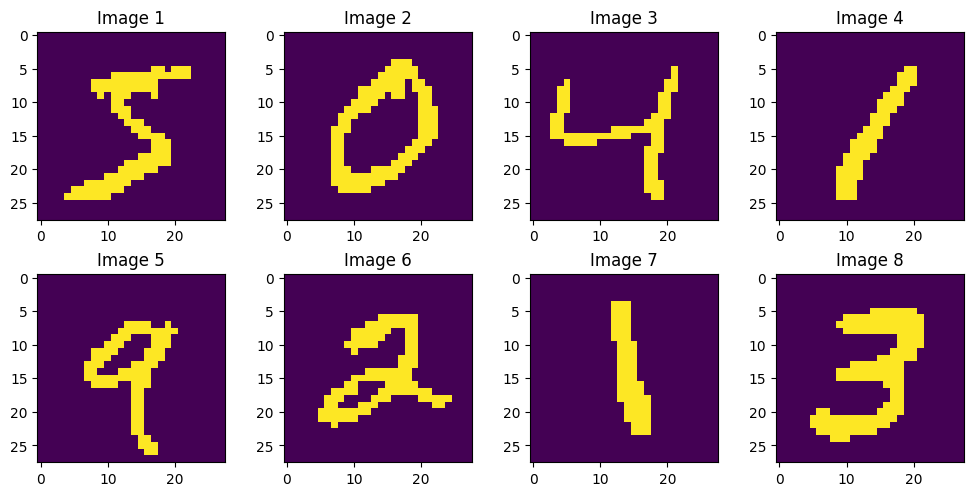

In [9]:
visualize_binary_vectors(x_train, 28, 28)

In [10]:
# define some useful variable
train_size = x_train.shape[0]
test_size = x_test.shape[0]
batch_size = 32

In [11]:
# Shuffle the data
train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(train_size)
test_data = tf.data.Dataset.from_tensor_slices(x_test).shuffle(test_size)

# Batch the data
train_data = train_data.batch(batch_size)
test_data = test_data.batch(batch_size)

## Define the network
VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$
\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].
$$

In practice, optimize the single sample Monte Carlo estimate of this expectation (`tf.reduce_mean(logpx_z + logpz - logqz_x)`):
$$
\log p(x| z) + \log p(z) - \log q(z|x)
$$


where $z$ is sampled from $q(z|x)$.

In [12]:
class ConvolutionalVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.Input(shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="valid",
                                       activation="relu"),
                tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="valid",
                                       activation="relu"),
                tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid",
                                       activation="relu"),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=latent_dim + latent_dim)  # No activation function in this layer
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7 * 7 * 32, activation="relu"),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean # return z, our latent vector
        #ssumes a diagonal covariance matrix (i.e., independent dimensions). Othwerwise use cholsy dec and matrix moltiplication

    def decode(self, z, apply_sigmoid=False):
      logits = self.decoder(z)
      if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
      return logits

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)


In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x) # computes the mean loss over all samples in the batch. 
    # we are performing monte carlo


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))



In [14]:
epochs = 10
latent_dim = 2 # set the dimensionality of the latent space to a plane for visualization later
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

model = ConvolutionalVAE(latent_dim)

In [15]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [16]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_data.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :,:]

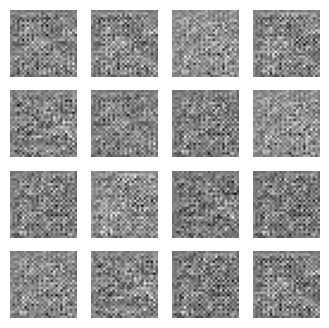

KeyboardInterrupt: 

In [17]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_data:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_data:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [ ]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

In [ ]:
plot_latent_images(model, 20)

# Reference
- Variational autoencoders, Matthew N. Bernstein, https://mbernste.github.io/posts/vae/
- https://keras.io/examples/generative/vae/